In [1]:
import sys
import re
import os
from datetime import datetime
from time import sleep
from IPython.display import display, clear_output, HTML

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import utils
from utils import *
import torch
import pandas as pd
import numpy as np
import torch
from glob import glob
import selenium
from tqdm.auto import tqdm

START_TS = datetime.now()
display(HTML(f'{START_TS} - Current working directory: <b>{WORKING_DIR}</b>'))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba



2021-06-10 12:12:15,343 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-10 12:12:15,345 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-10 12:12:15,346 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-10 12:12:15,348 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-10 12:12:15,974 -INFO - dataset:dataset.py:653 - dataset module is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

# Parameters

In [4]:
SITE_URL = 'https://jdi-testing.github.io/jdi-light/'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

In [5]:
with open('dataset/classes.txt', 'r') as f:
    decoder_dict = { i:s.strip() for i, s in  enumerate(f.readlines())}
decoder_dict

{0: 'button',
 1: 'link',
 2: 'textfield',
 3: 'dropdown',
 4: 'checkbox',
 5: 'radiobutton',
 6: 'textarea',
 7: 'fileinput',
 8: 'iframe',
 9: 'range',
 10: 'progressbar',
 11: 'datetimeselector',
 12: 'colorpicker',
 13: 'numberselector',
 14: 'selector',
 15: 'table',
 16: 'slider-toggle',
 17: 'slider',
 18: 'tree-node',
 19: 'steper',
 20: 'tab',
 21: 'n/a'}

# Generate dataset

2021-06-10 12:12:16,103 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: search
2021-06-10 12:12:16,104 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-10 12:12:16,105 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-10 12:12:17,216 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-10 12:12:17,217 -INFO - <ipython-input-6-9aa03baef139>:<ipython-input-6-9aa03baef139>:5 - getting page
2021-06-10 12:12:25,475 -INFO - common:common.py:75 - Window maximized
2021-06-10 12:12:32,486 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/search.png
2021-06-10 12:12:32,565 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-10 12:12:32,790 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/search.html
2021-06-10 12:12:32,797 -INFO - dataset_builder:dataset_builder.py:196 - Save parquet to da

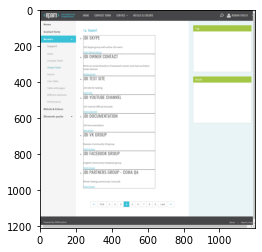

In [6]:
DATASET_NAME = 'search'
class JDIDatasetBuilder(DatasetBuilder):

    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_URL)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Search").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))



In [7]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')

In [8]:
df = build_features(df)

2021-06-10 12:12:33,224 -INFO - hidden:hidden.py:107 - build field "is_hidden"


In [9]:
elements_dict = build_elements_dict(df)

In [10]:
df[['tag_name', 'element_id', 'parent_id', 'upper_sibling', 'lower_sibling', 'displayed', 'is_hidden', 'x', 'y', 'width', 'height']]

,tag_name,element_id,parent_id,upper_sibling,lower_sibling,displayed,is_hidden,x,y,width,height
0,HTML,4332429079163525696558960487,None,None,None,True,0,0.000000,0.0,1183.000000,1193.0
1,HEAD,0499303069163525691478650043,4332429079163525696558960487,None,7397178409163525694975233350,False,0,0.000000,0.0,0.000000,0.0
2,META,6710217608163525699193075174,0499303069163525691478650043,None,3970034295163525693426112948,False,0,0.000000,0.0,0.000000,0.0
3,TITLE,3970034295163525693426112948,0499303069163525691478650043,6710217608163525699193075174,7361219592163525690048046014,False,0,0.000000,0.0,0.000000,0.0
4,META,7361219592163525690048046014,0499303069163525691478650043,3970034295163525693426112948,4378630879163525696911027141,False,0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
292,A,9416787026163525697476015859,3980794263163525699195426482,None,None,True,0,1115.890625,1171.0,64.109375,15.0
293,SCRIPT,7304199880163525695241444724,7397178409163525694975233350,4126554453163525692475473108,9330453658163525699934895740,False,1,0.000000,0.0,0.000000,0.0
294,SCRIPT,9330453658163525699934895740,7397178409163525694975233350,7304199880163525695241444724,0685991053163525697495391742,False,1,0.000000,0.0,0.000000,0.0
295,SCRIPT,0685991053163525697495391742,7397178409163525694975233350,9330453658163525699934895740,6275371381163525697684547733,False,1,0.000000,0.0,0.000000,0.0


In [11]:
# img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
# img_height, img_width = img.shape
# print(img_width, img_height)
# plt.figure(figsize=(15, 100))
# plt.imshow(img, cmap='gray')

In [12]:
predictions_df = rule_base_predict(df)
print(predictions_df.shape)
# predictions_df

2021-06-10 12:12:33,639 -INFO - common:common.py:491 - Num radio buttons found: 0
2021-06-10 12:12:33,641 -INFO - common:common.py:495 - Num radio2 buttons found: 0
2021-06-10 12:12:33,643 -INFO - common:common.py:502 - Num checkboxes found: 0
2021-06-10 12:12:33,645 -INFO - common:common.py:509 - Num comboboxes/dropdowns found: 0
2021-06-10 12:12:33,647 -INFO - common:common.py:520 - Num textfields found: 2
2021-06-10 12:12:33,650 -INFO - common:common.py:525 - Num texfields for numbers found: 0
2021-06-10 12:12:33,653 -INFO - common:common.py:530 - Num ranges found: 0
2021-06-10 12:12:33,655 -INFO - common:common.py:535 - Num ordinary text inputs found: 0
2021-06-10 12:12:33,657 -INFO - common:common.py:538 - Num buttons found: 2
2021-06-10 12:12:33,658 -INFO - common:common.py:543 - Num buttons1 found: 1
2021-06-10 12:12:33,661 -INFO - common:common.py:548 - Num buttons2 (Material-UI) found: 0
2021-06-10 12:12:33,663 -INFO - common:common.py:553 - Num links found: 60
(44, 8)


1200 1210


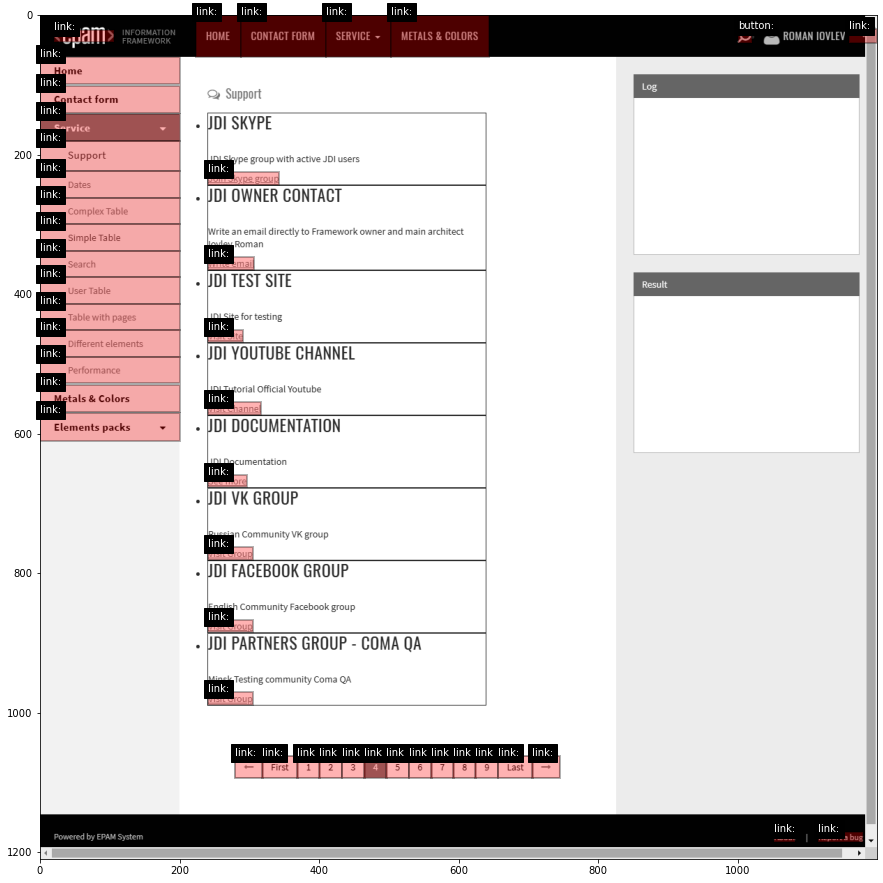

In [13]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 100))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for _, r in predictions_df.iterrows():
    
    patch = patches.Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    axes.add_patch(patch)
    plt.text(r.x, r.y, 
             decoder_dict[r.label] + ':',  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
    

# Generate and Save Labels

In [14]:
# labels = build_to_yolo(df = predictions_df, img_width=img_width, img_heght=img_height)
# labels

In [15]:
# labeled_df = pd.DataFrame(labels, columns=['label', 'x', 'y', 'width', 'height'])
# labeled_df.label = labeled_df.label.astype(int)
# display(labeled_df)
# labeled_df.to_csv(f'dataset/annotations/{DATASET_NAME}.txt', header=False, sep=' ', index=False)

# Preview Labels

In [16]:
boxes_df = pd.read_csv(f'dataset/annotations/{DATASET_NAME}.txt', sep=' ', names = ['label', 'x', 'y', 'width', 'height'])
boxes_df
boxes_df['box'] = boxes_df.apply(lambda r: from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height), axis=1)
boxes_df.head()

,label,x,y,width,height,box
0,0,0.841667,0.023967,0.016667,0.016529,"(1000, 19, 20, 20)"
1,1,0.052083,0.023967,0.072500,0.014876,"(18, 20, 87, 17)"
2,1,0.212083,0.024793,0.054167,0.047934,"(221, 0, 65, 58)"
3,1,0.290000,0.024793,0.101667,0.047934,"(286, 0, 122, 58)"
4,1,0.379583,0.024793,0.077500,0.047934,"(408, 0, 93, 58)"


1200 1210


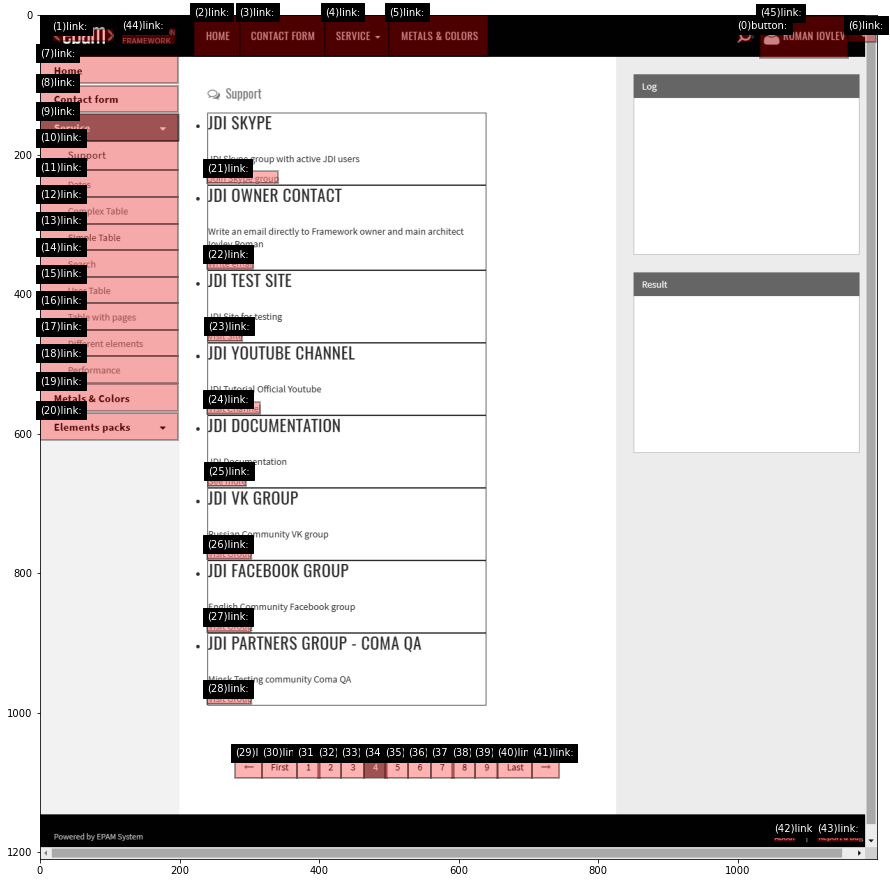

In [17]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 100))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for i, r in boxes_df.iterrows():
    x, y, w, h = from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height)    
    patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    axes.add_patch(patch)
    plt.text(x, y, 
             f'({i})' + decoder_dict[r.label] + ':',  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
    

In [18]:
# df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings'],
      dtype='object')

In [19]:
df = assign_labels(df=df, annotations_file_path=f'dataset/annotations/{DATASET_NAME}.txt', img_width=img_width, img_height=img_height)

2021-06-10 12:12:34,928 -INFO - labels:labels.py:41 - Assign labels from annotation file: dataset/annotations/search.txt
2021-06-10 12:12:34,929 -INFO - labels:labels.py:43 - Getting image size
2021-06-10 12:12:34,930 -INFO - labels:labels.py:45 - Image size (w,h): (1200, 1210)
2021-06-10 12:12:34,930 -INFO - labels:labels.py:50 - {'button': 0, 'link': 1, 'textfield': 2, 'dropdown': 3, 'checkbox': 4, 'radiobutton': 5, 'textarea': 6, 'fileinput': 7, 'iframe': 8, 'range': 9, 'progressbar': 10, 'datetimeselector': 11, 'colorpicker': 12, 'numberselector': 13, 'selector': 14, 'table': 15, 'slider-toggle': 16, 'slider': 17, 'tree-node': 18, 'steper': 19, 'tab': 20, 'n/a': 21}
2021-06-10 12:12:34,931 -INFO - labels:labels.py:58 - getting "n/a" class code
2021-06-10 12:12:34,931 -INFO - labels:labels.py:65 - "n/a" class code: 21
2021-06-10 12:12:34,933 -INFO - labels:labels.py:75 - 46 annotation has been read


Assign labels:   0%|          | 0/46 [00:00<?, ?it/s]

2021-06-10 12:12:36,489 -INFO - labels:labels.py:124 - labels_df: Index(['idx', 'label', 'annotation_line_no', 'iou', 'tag', 'label_text'], dtype='object')
2021-06-10 12:12:36,489 -INFO - labels:labels.py:127 - 46 labels have been assigned


In [20]:
# df = build_labels(df=df, annotations_file_path=f'dataset/annotations/{DATASET_NAME}.txt', img_width=0, img_height=0)

In [21]:
df.label.value_counts()

21    251
1      45
0       1
Name: label, dtype: int64

1200 1210


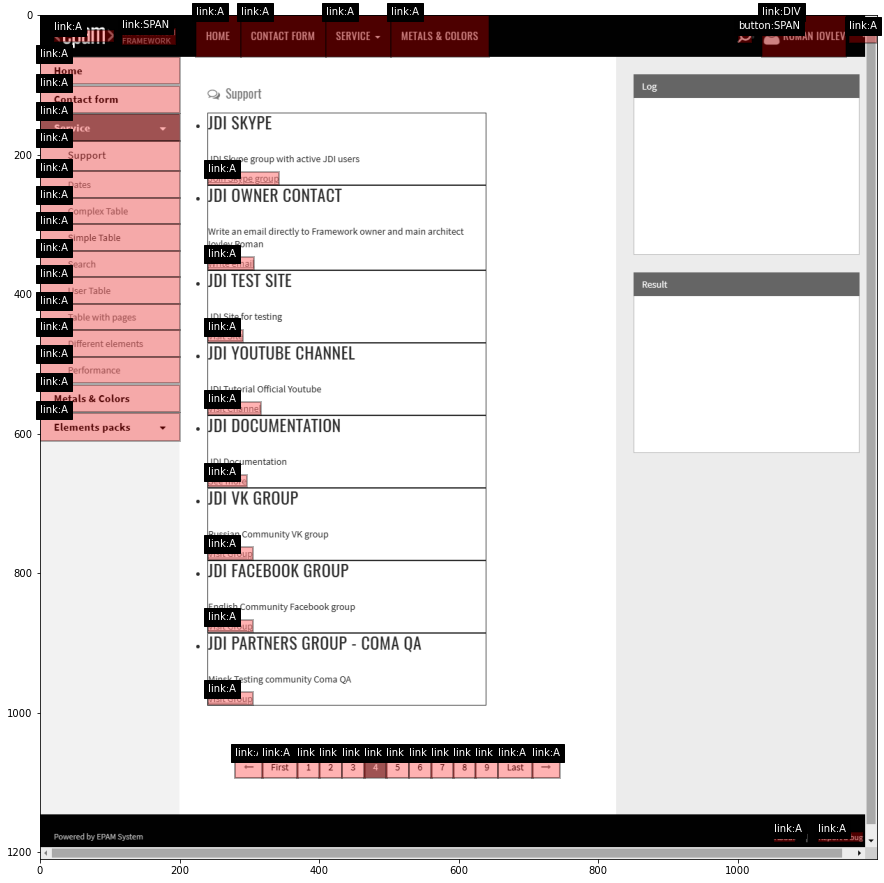

In [22]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 100))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for _, r in df[df.label_text != 'n/a'].iterrows():
    x, y, w, h = r.x, r.y, r.width, r.height  
    patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    
    # print(r.tag_name, r.label_text, (x,y,w,h), r.element_id)
    
    axes.add_patch(patch)
    plt.text(x, y, 
             decoder_dict[r.label] + ':' + r.tag_name, # + ':' + str((x, y, w, h)),  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
